In [10]:
# Reload the Jupyter notebook kernel
# %load_ext autoreload
%reload_ext autoreload
%autoreload 2

import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import importlib
import dataset_preparation
import matlab.engine
from sklearn.metrics import roc_curve, auc , confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from keras.models import load_model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.optimizers import RMSprop
from dataset_preparation import awgn, LoadDataset, ChannelIndSpectrogram
from deep_learning_models import TripletNet, identity_loss

importlib.reload(dataset_preparation)

from dataset_preparation import LoadDataset

In [12]:
# if you want to reconnect -- run:
mateng.quit()

mateng = matlab.engine.connect_matlab('mobintel_augmentation')

In [13]:
def train_feature_extractor(data, label, dev_range):    
    ChannelIndSpectrogramObj = ChannelIndSpectrogram()
    
    # Convert time-domain IQ samples to channel-independent spectrograms.
    data = ChannelIndSpectrogramObj.channel_ind_spectrogram(data)

    # Specify hyper-parameters during training.
    margin = 0.1
    batch_size = 32
    patience = 15
    
    TripletNetObj = TripletNet()
    
    # Create an RFF extractor.
    feature_extractor = TripletNetObj.feature_extractor(data.shape)
    
    # Create the Triplet net using the RFF extractor.
    triplet_net = TripletNetObj.create_triplet_net(feature_extractor, margin)

    # Create callbacks during training. The training stops when validation loss 
    # does not decrease for 30 epochs.
    early_stop = EarlyStopping('val_loss', min_delta = 0, patience = patience)
    
    reduce_lr = ReduceLROnPlateau('val_loss', min_delta = 0, factor = 0.2, patience = 10, verbose=1)
    callbacks = [early_stop, reduce_lr]
    
    # Split the dasetset into validation and training sets.
    data_train, data_valid, label_train, label_valid = train_test_split(data, label, test_size=0.1, shuffle= True)
    del data, label
    
    # Create the trainining generator.
    train_generator = TripletNetObj.create_generator(batch_size, dev_range,  data_train, label_train)
    # Create the validation generator.
    valid_generator = TripletNetObj.create_generator(batch_size, dev_range, data_valid, label_valid)
    
    # Use the RMSprop optimizer for training.
    opt = RMSprop(learning_rate=1e-3)
    triplet_net.compile(loss = identity_loss, optimizer = opt)

    # Start training.
    history = triplet_net.fit(train_generator,
                              steps_per_epoch = data_train.shape[0]//batch_size,
                              epochs = 1000,
                              validation_data = valid_generator,
                              validation_steps = data_valid.shape[0]//batch_size,
                              verbose=1, 
                              callbacks = callbacks)
    
    return feature_extractor

def test_classification(file_path_enrol, file_path_clf, feature_extractor, dev_range_enrol, pkt_range_enrol, dev_range_clf, pkt_range_clf):
    
    # Load the saved RFF extractor.
    # feature_extractor = load_model(feature_extractor_name, compile=False)
    
    LoadDatasetObj = LoadDataset()
    
    # Load the enrollment dataset. (IQ samples and labels)
    data_enrol, label_enrol = LoadDatasetObj.load_iq_samples(file_path_enrol,  dev_range_enrol, pkt_range_enrol)
    
    print(f"Data enrol shape: {data_enrol.shape}")
    
    ChannelIndSpectrogramObj = ChannelIndSpectrogram()
    
    # Convert IQ samples to channel independent spectrograms. (enrollment data)
    data_enrol = ChannelIndSpectrogramObj.channel_ind_spectrogram(data_enrol)
    
    # Extract RFFs from channel independent spectrograms.
    print("Generating enrollment fingerprints...")
    feature_enrol = feature_extractor.predict(data_enrol)
    del data_enrol
    
    # Create a K-NN classifier using the RFFs extracted from the enrollment dataset.
    knnclf=KNeighborsClassifier(n_neighbors=20,metric='euclidean')
    knnclf.fit(feature_enrol, np.ravel(label_enrol))
    
    # Load the classification dataset. (IQ samples and labels)
    data_clf, true_label = LoadDatasetObj.load_iq_samples(file_path_clf, dev_range_clf, pkt_range_clf)
    
    print(f"Data identify shape: {data_clf.shape}")
    
    # Convert IQ samples to channel independent spectrograms. (classification data)
    data_clf = ChannelIndSpectrogramObj.channel_ind_spectrogram(data_clf)

    # Extract RFFs from channel independent spectrograms.
    print("Generating fingerprints for comparison")
    feature_clf = feature_extractor.predict(data_clf)
    del data_clf
    
    # Make prediction using the K-NN classifier.
    pred_label = knnclf.predict(feature_clf)

    # Calculate classification accuracy.
    acc = accuracy_score(true_label, pred_label)
    print('Overall accuracy = %.4f' % acc)
    
    return pred_label, true_label, acc

def evaluate(true_label, pred_label, classes):
    conf_mat = confusion_matrix(true_label, pred_label, normalize='true')
    # classes = np.arange(0, 10, dtype = int) + 1

    plt.figure()
    sns.heatmap(conf_mat, annot=True, 
                cmap='Blues',
                cbar = False,
                xticklabels=classes, 
                yticklabels=classes)
    plt.xlabel('Predicted label', fontsize = 20)
    plt.ylabel('True label', fontsize = 20)
    plt.show()


In [14]:
root_path_v1 = '/home/smazokha2016/Desktop/orbit_dataset_v1'
root_path_v2_jul19 = '/home/smazokha2016/Desktop/mobintel-orbit-dataset_h5'
root_path_v2_jul21 = '/home/smazokha2016/Desktop/orbit_dataset_v2_jul21'

# Dataset: Orbit v1 (manual capture)
dataset_train = os.path.join(root_path_v1, 'training_2024-07-13_06-53-20', 'node1-1_non_eq_train.h5')
dataset_enrol = os.path.join(root_path_v1, 'epoch_2024-07-13_07-40-21', 'node1-1_non_eq_test.h5')
dataset_identify = os.path.join(root_path_v1, 'epoch_2024-07-13_07-52-31', 'node1-1_non_eq_test.h5')
model_path = os.path.join(root_path_v1, 'my_models')

# # Dataset: Orbit v2 (automated capture)
# dataset_train = os.path.join(root_path_v2_jul21, 'node1-1_training_2024-07-21_14-49-09.h5')
# dataset_enrol = os.path.join(root_path_v2_jul21, 'node1-1_epoch_2024-07-21_16-02-04.h5')
# dataset_identify = os.path.join(root_path_v2_jul21, 'node1-1_epoch_2024-07-21_16-26-15.h5')
# # dataset_identify = os.path.join(root_path_v2, 'node1-1_epoch_2024-07-21_20-20-50.h5')
# model_path = os.path.join(root_path_v2_jul21, 'my_models')

In [15]:
def show_dataset_devices(dataset_labels):
    devices = list(set(dataset_labels.flatten()))
    devices.sort()
    print(devices)

show_dataset_devices(LoadDataset().load_iq_samples(dataset_train, None, np.arange(0, 400))[1])
show_dataset_devices(LoadDataset().load_iq_samples(dataset_enrol, None, np.arange(0, 100))[1])
show_dataset_devices(LoadDataset().load_iq_samples(dataset_identify, None, np.arange(0, 100))[1])

[9, 11, 15, 17, 18, 25, 38, 52, 57, 60, 69, 70, 80, 84, 129, 133, 142, 147, 157, 159, 190, 196, 203, 206, 216, 266, 360, 391, 399]
[239, 266, 269, 280, 300, 315, 330, 380, 394, 398]
[239, 266, 269, 280, 300, 315, 330, 380, 394, 398]


In [16]:
# Devices from Orbit v1 dataset
dev_range = np.array([9, 11, 15, 17, 18, 25, 38, 52, 57, 60, 69, 70, 80, 84, 129, 133, 142, 147, 157, 159, 190, 196, 203, 206, 216, 266, 360, 391, 399])
pkt_range = np.arange(0, 400)

# Devices from Orbit v2 dataset (Jul 21)
# dev_range = np.array([9, 11, 15, 17, 25, 38, 52, 57, 60, 69, 70, 80, 84, 129, 133, 142, 147, 157, 159, 190, 203, 206, 216, 266, 360, 399])
# pkt_range = np.arange(0, 100)

ENABLE_AUGMENTATION = False

if ENABLE_AUGMENTATION:
    # 1. Read & augment the dataset in Matlab
    t_rms_bounds = matlab.double([5, 300])
    d_f_bounds = matlab.double([0, 10])
    k_factor_bounds = matlab.double([0, 10])
    N = 30

    mateng.cd('/home/smazokha2016/Desktop/mobintel-rffi/fingerprinting/lora_rffi_working', nargout=0)
    result = mateng.augmentation(dataset_train, 20e6, t_rms_bounds, d_f_bounds, k_factor_bounds, N)
    data = np.array(result['data_aug']).swapaxes(0, 1)
    label = np.array(result['label_aug']).swapaxes(0, 1)
else:
    data, label = LoadDataset().load_iq_samples(dataset_train, dev_range, pkt_range)

# 2. Shuffle the order of frames/labels
data, label = LoadDataset().shuffle(data, label)

# 3. Add AWGN
data = awgn(data, np.arange(20, 80))

# 4. Train the model
feature_extractor = train_feature_extractor(data, label, dev_range)
feature_extractor.save(model_path)

Epoch 1/1000
326/326 [==============================] - 8s 18ms/step - loss: 0.0118 - val_loss: 0.0086 - lr: 0.0010
Epoch 2/1000
326/326 [==============================] - 6s 18ms/step - loss: 0.0044 - val_loss: 0.0021 - lr: 0.0010
Epoch 3/1000
326/326 [==============================] - 6s 18ms/step - loss: 0.0015 - val_loss: 0.0017 - lr: 0.0010
Epoch 4/1000
326/326 [==============================] - 6s 18ms/step - loss: 0.0011 - val_loss: 8.7389e-04 - lr: 0.0010
Epoch 5/1000
326/326 [==============================] - 6s 18ms/step - loss: 6.9917e-04 - val_loss: 6.9419e-04 - lr: 0.0010
Epoch 6/1000
326/326 [==============================] - 6s 18ms/step - loss: 6.8194e-04 - val_loss: 3.4547e-04 - lr: 0.0010
Epoch 7/1000
326/326 [==============================] - 6s 18ms/step - loss: 5.3045e-04 - val_loss: 5.6282e-05 - lr: 0.0010
Epoch 8/1000
326/326 [==============================] - 6s 18ms/step - loss: 2.6850e-04 - val_loss: 8.7174e-05 - lr: 0.0010
Epoch 9/1000
326/326 [==============

INFO:tensorflow:Assets written to: /home/smazokha2016/Desktop/orbit_dataset_v1/my_models/assets


INFO:tensorflow:Assets written to: /home/smazokha2016/Desktop/orbit_dataset_v1/my_models/assets


In [17]:
from scipy.spatial.distance import pdist, squareform, cdist

importlib.reload(dataset_preparation)

from dataset_preparation import LoadDataset, ChannelIndSpectrogram, awgn

# Epochs from Orbit v1 dataset
epochs = [f for f in os.listdir(root_path_v1) if f.startswith('epoch_')]

# Epochs from Orbit v2 (Jul 19) dataset
# epochs = [f for f in os.listdir(root_path_v2_jul19) if f.startswith('node1-1_epoch')]

# Epochs from Orbit v2 (Jul 21) dataset
# epochs = [f for f in os.listdir(root_path_v2_jul21) if f.startswith('node1-1_epoch')]

# # Orbit v1 testing devices
dev_range = np.array([239, 266, 269, 280, 300, 315, 330, 380, 394, 398])

# Orbit v2 testing devices
# dev_range = np.array([1, 10, 20, 39, 239, 269, 280, 300, 315, 394, 398])

N = len(dev_range) # of devices
M = len(epochs)
K = 100 # of frames per epoch
FL_LEN = 512 # length of a single fingerprint
pkt_range = np.arange(0, K)

fingerprints = np.zeros(shape=(N, M, K, FL_LEN))

ChannelIndSpectrogramObj = ChannelIndSpectrogram()
for m in np.arange(M):
    print('.', end='')

    try:
        epoch_path = os.path.join(root_path_v1, epochs[m], 'node1-1_non_eq_test.h5') # for Orbit v1 dataset
        # epoch_path = os.path.join(root_path_v2_jul19, epochs[m])
        # epoch_path = os.path.join(root_path_v2_jul21, epochs[m]) # for Orbit v2 (Jul 21) dataset
        
        data, label = LoadDataset().load_iq_samples(epoch_path, dev_range, pkt_range)
        # data = awgn(data, np.arange(20, 80))

        data = ChannelIndSpectrogramObj.channel_ind_spectrogram(data)

        data_fps = feature_extractor.predict(data)

        data_fps_reshaped = data_fps.reshape(N, K, data_fps.shape[1])

        for n, device_id in enumerate(dev_range):
            for k in np.arange(K):
                fingerprints[n, m, k, :] = data_fps_reshaped[n, k, :]
    except Exception as e:
        print(e)

32/32 [==============================] - 0s 2ms/step


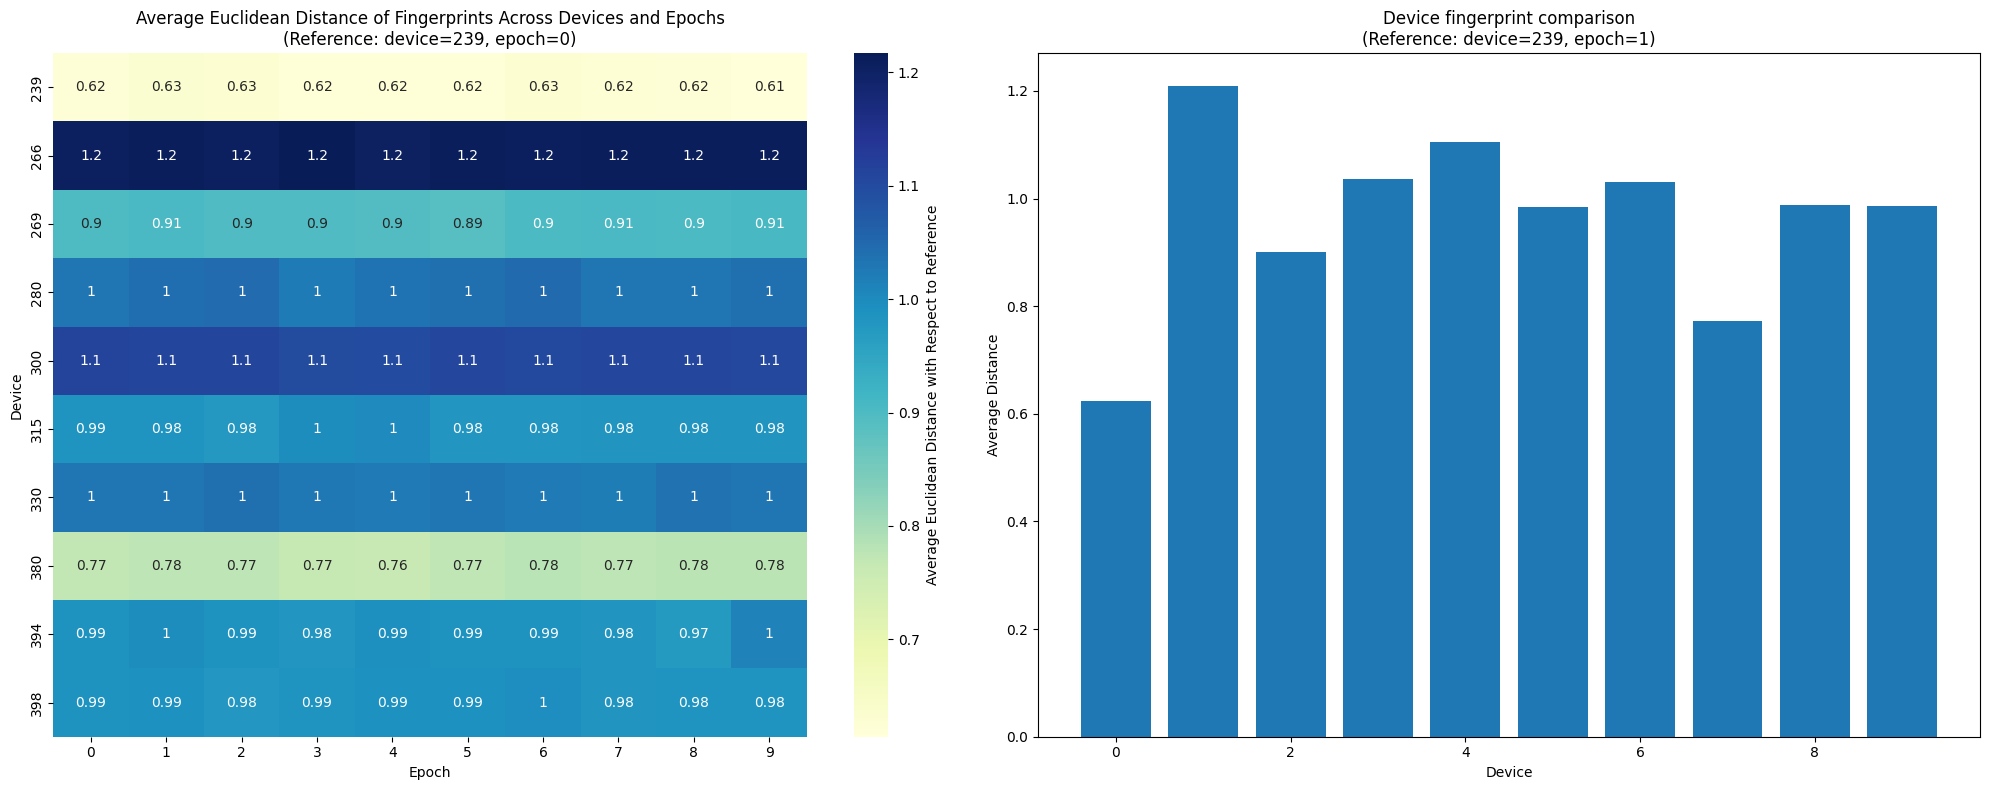

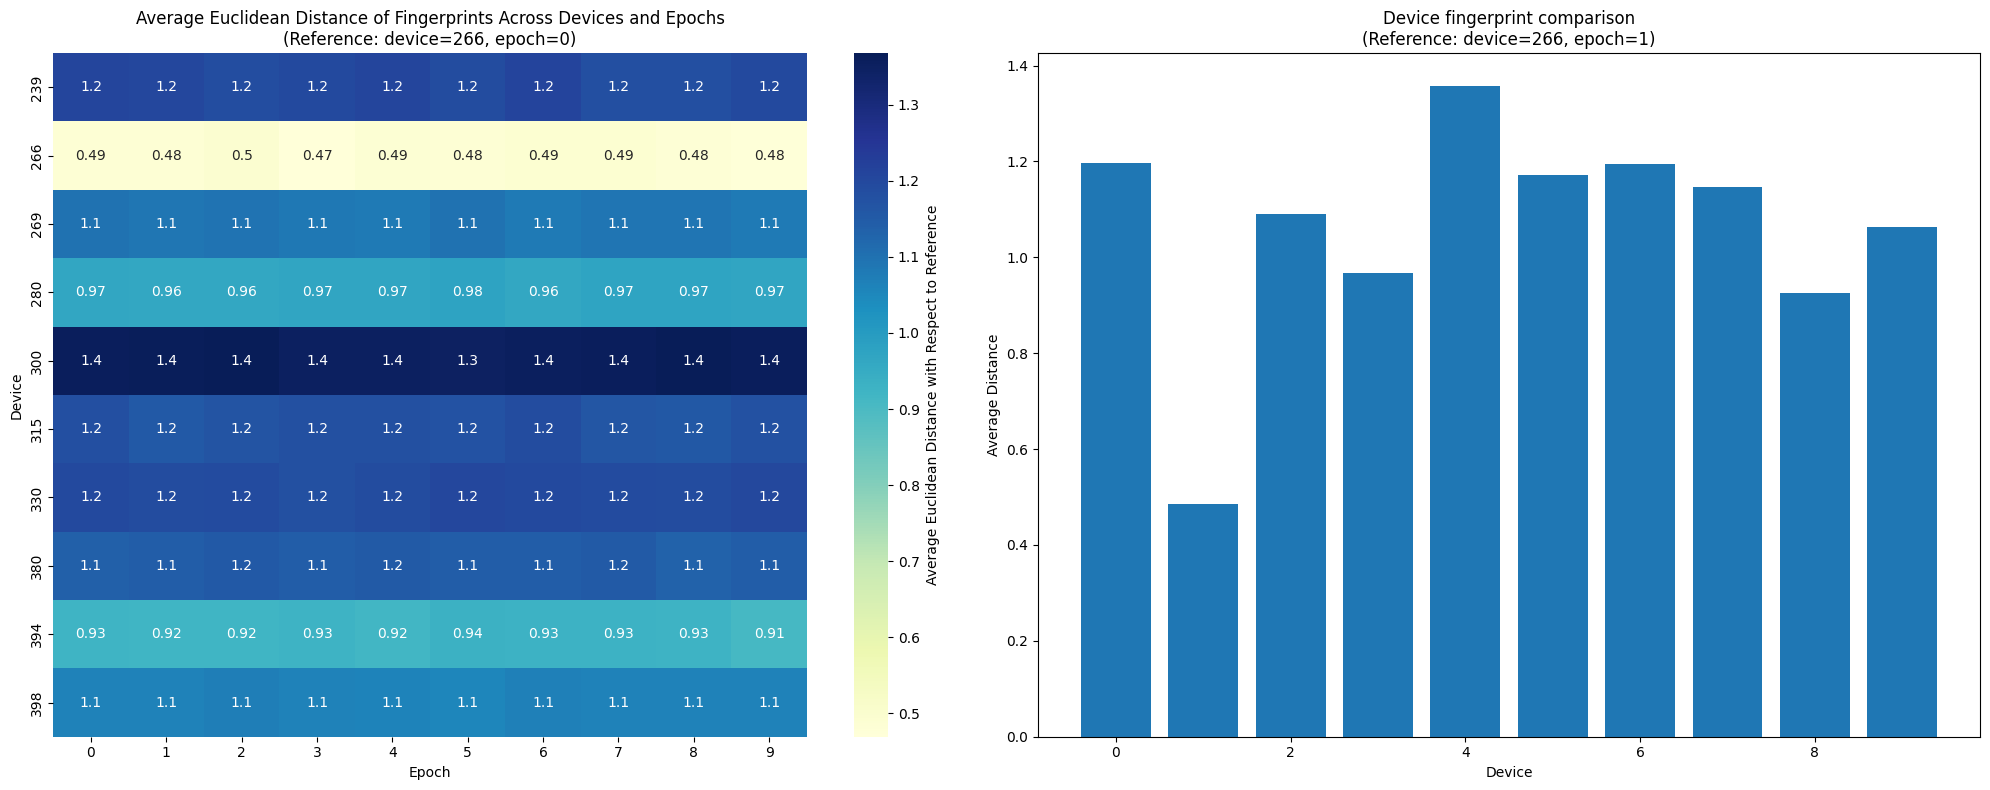

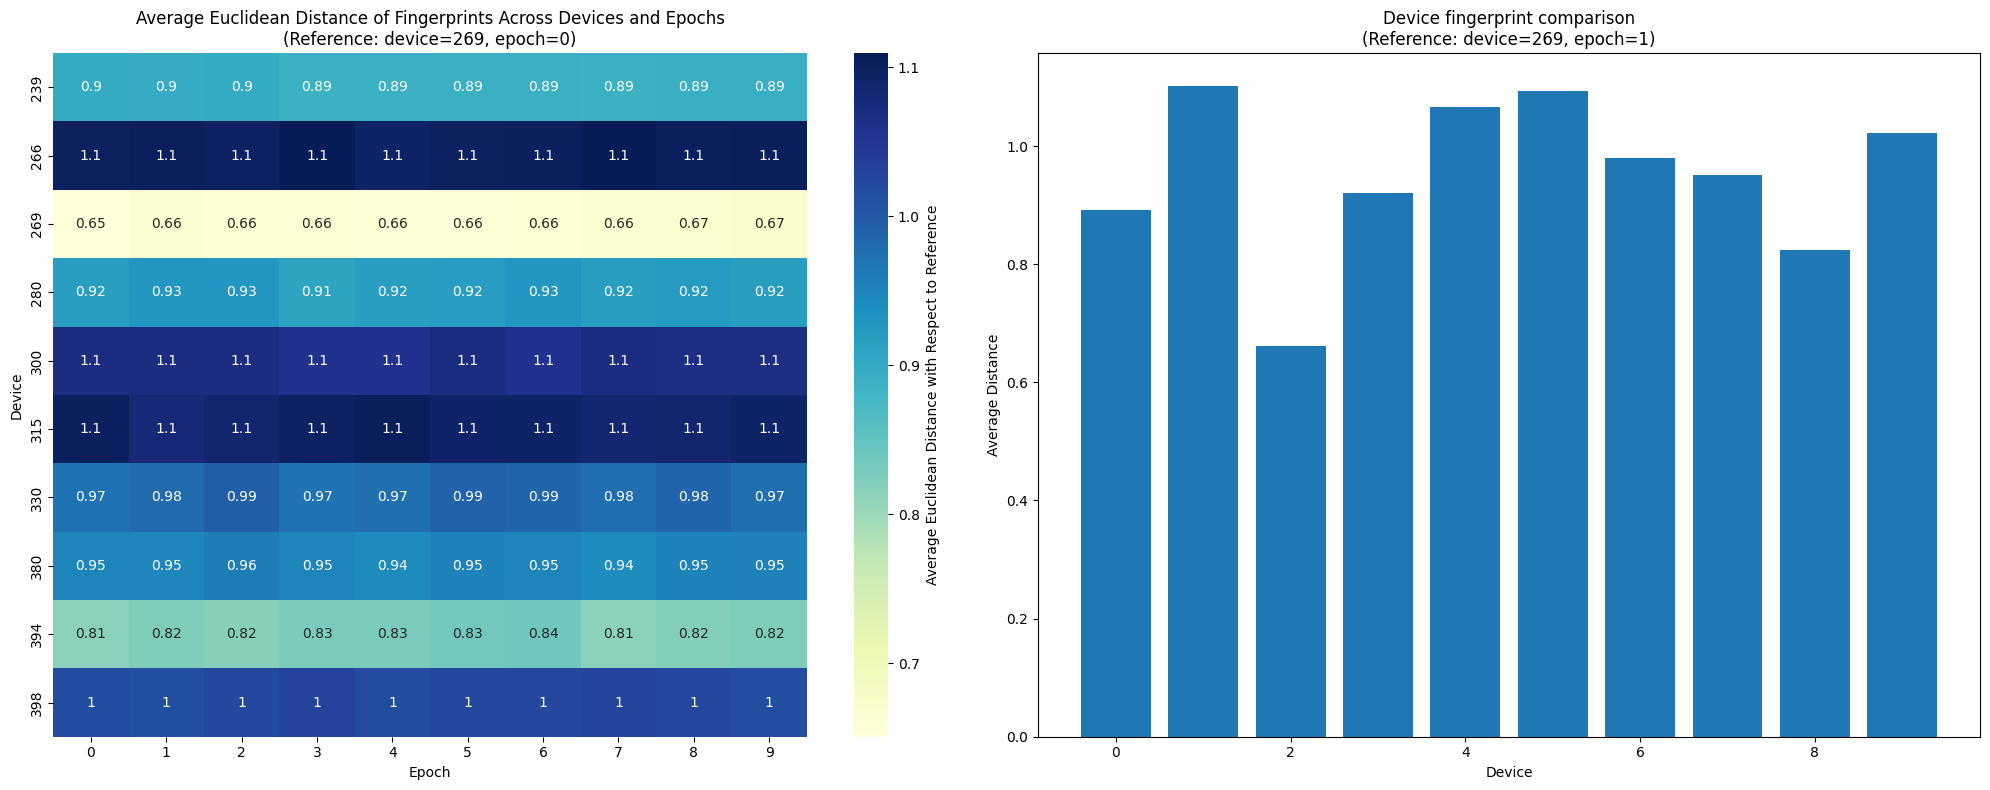

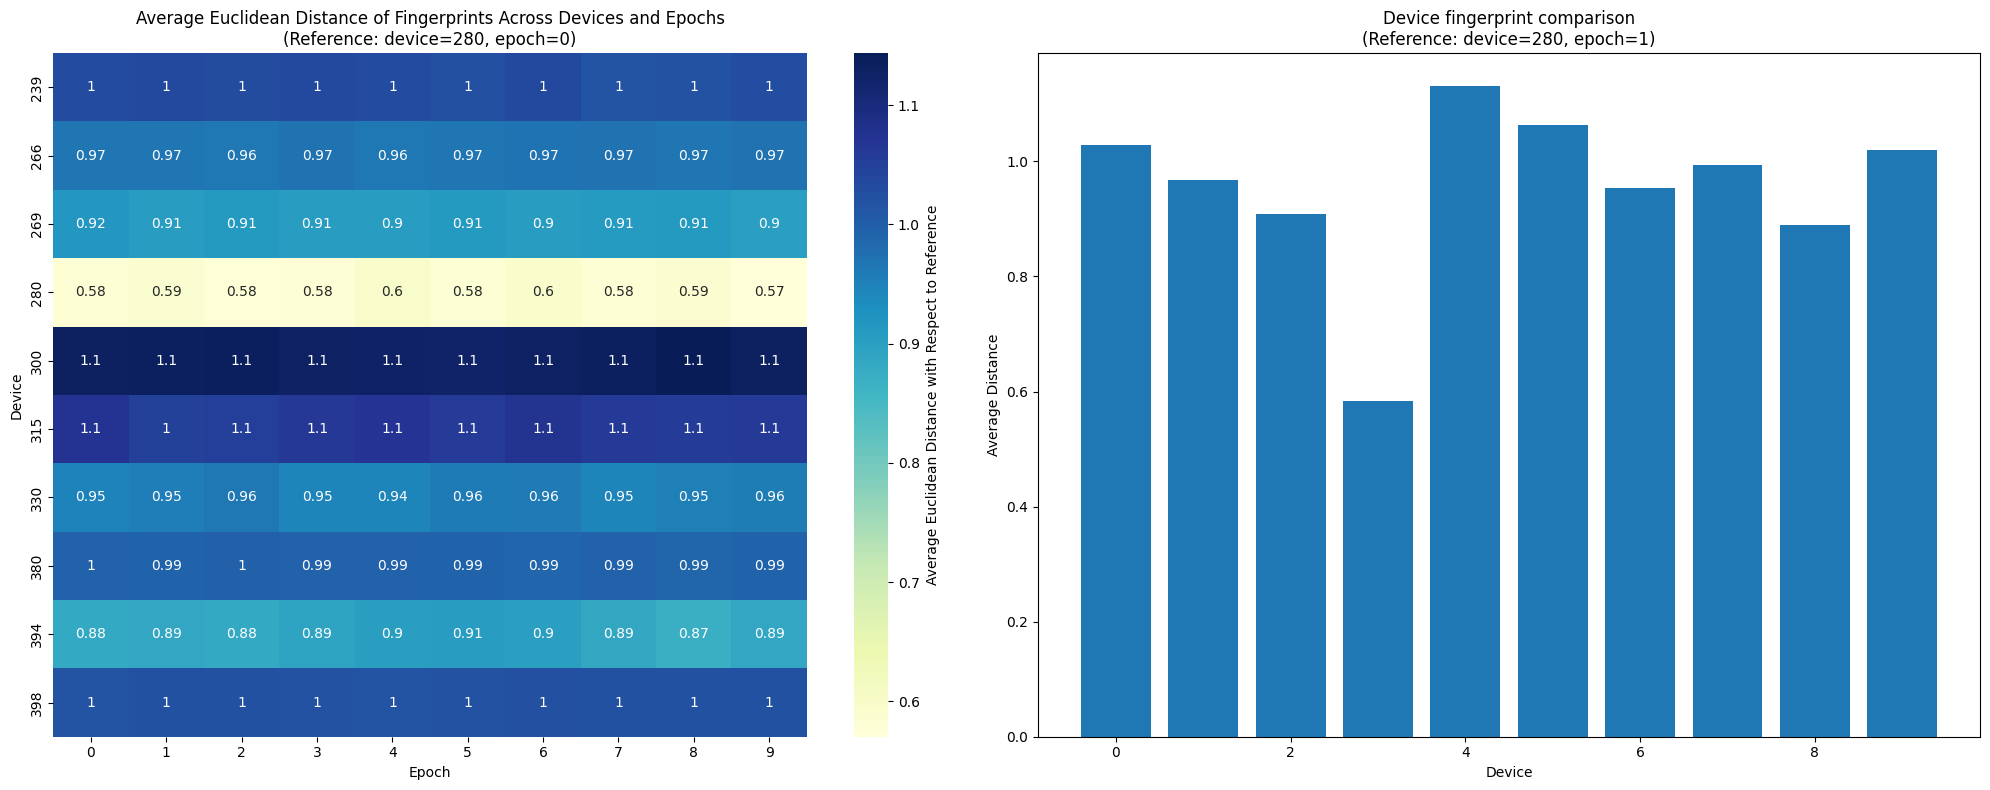

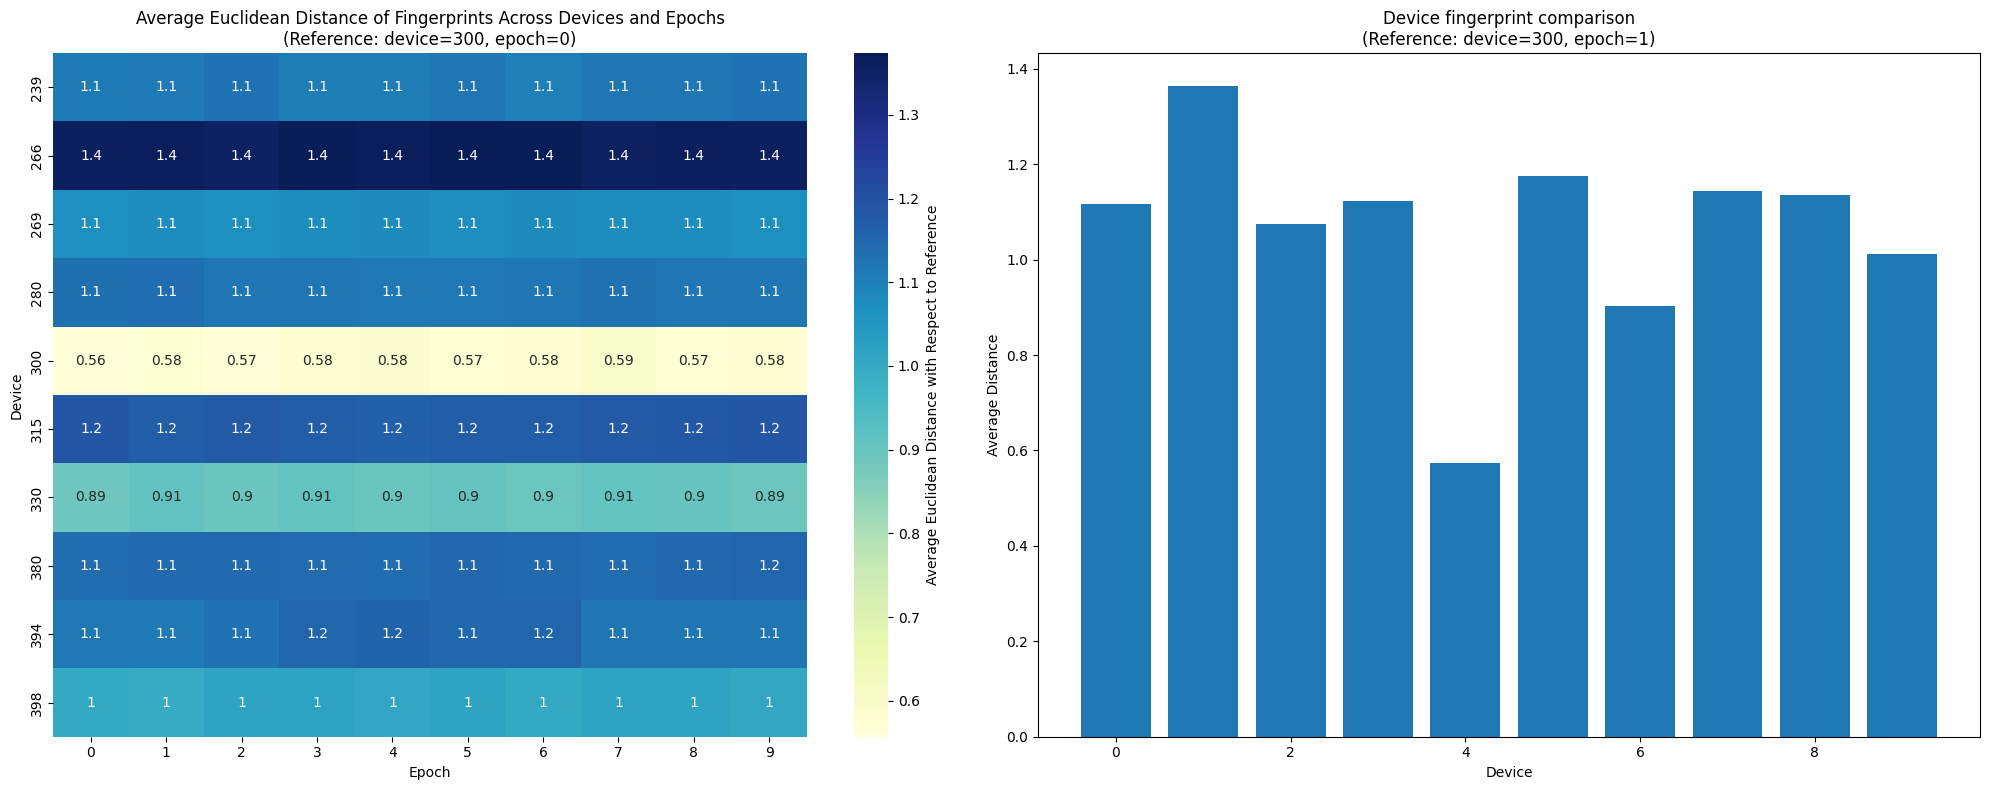

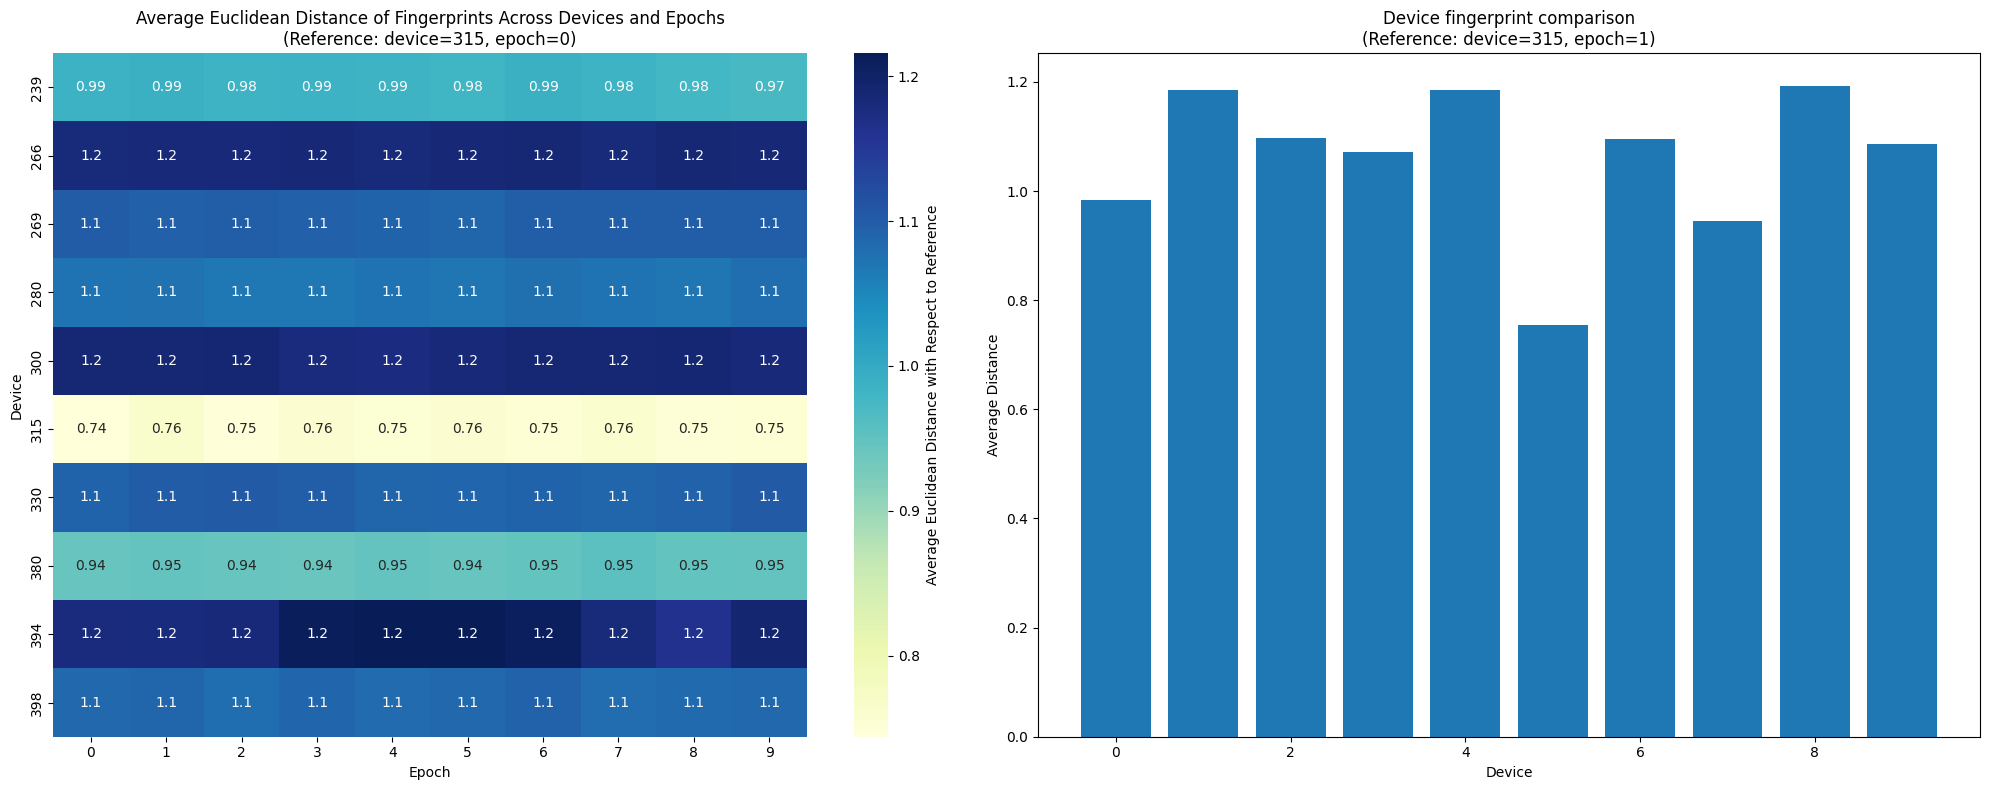

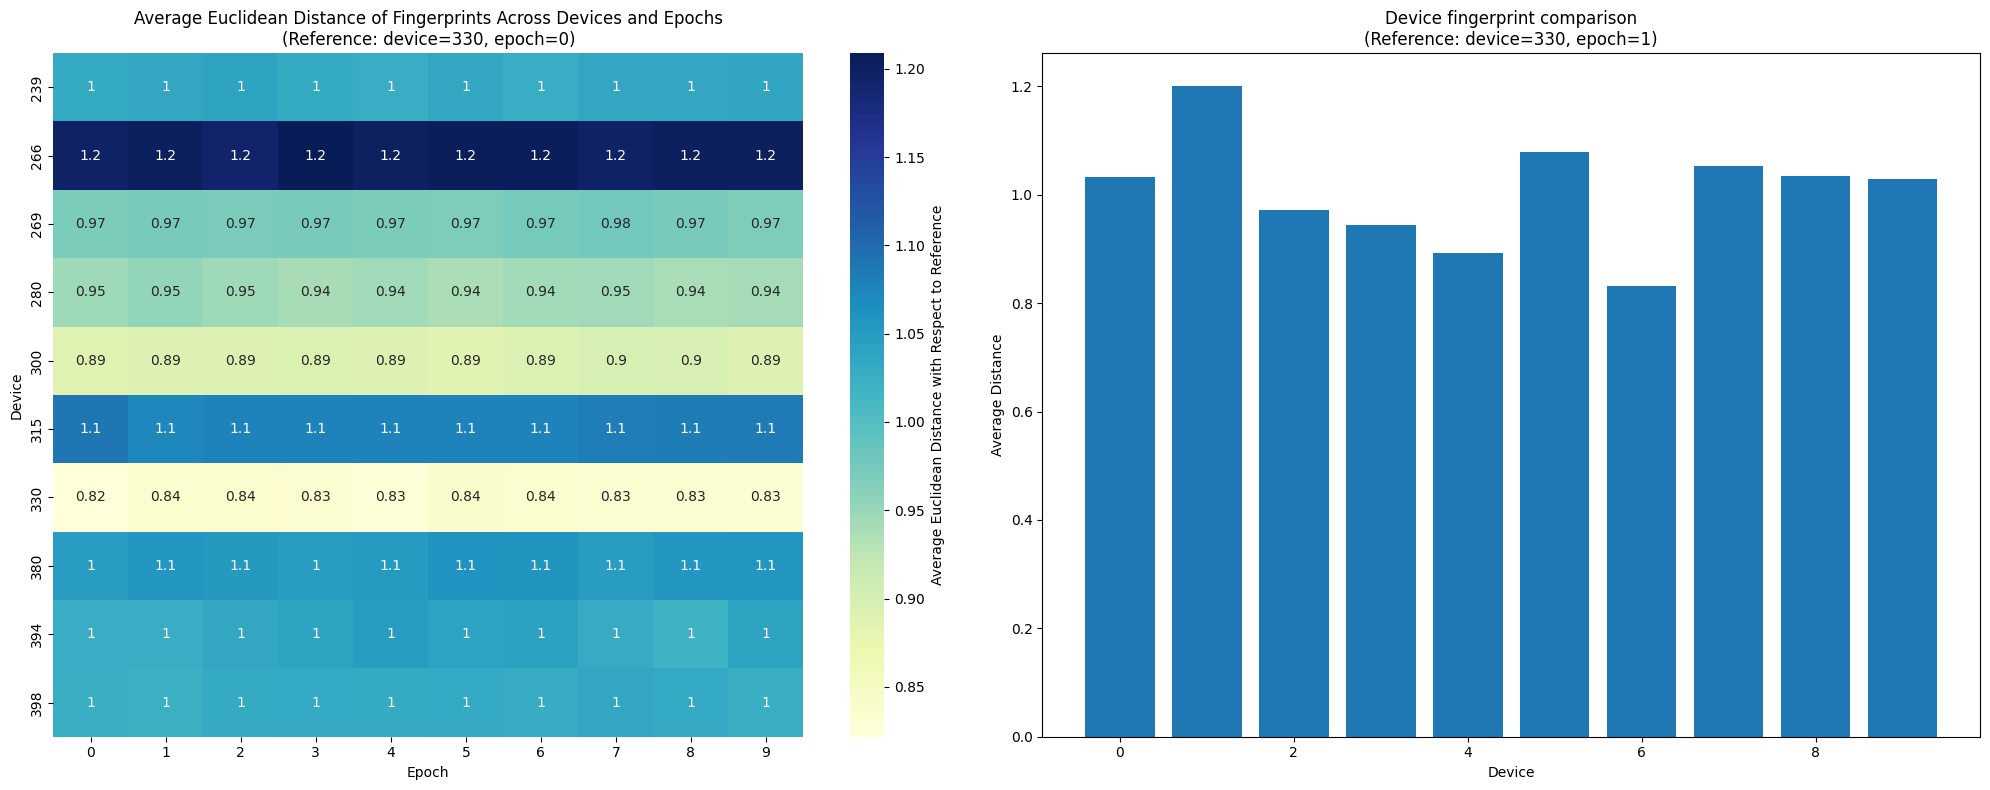

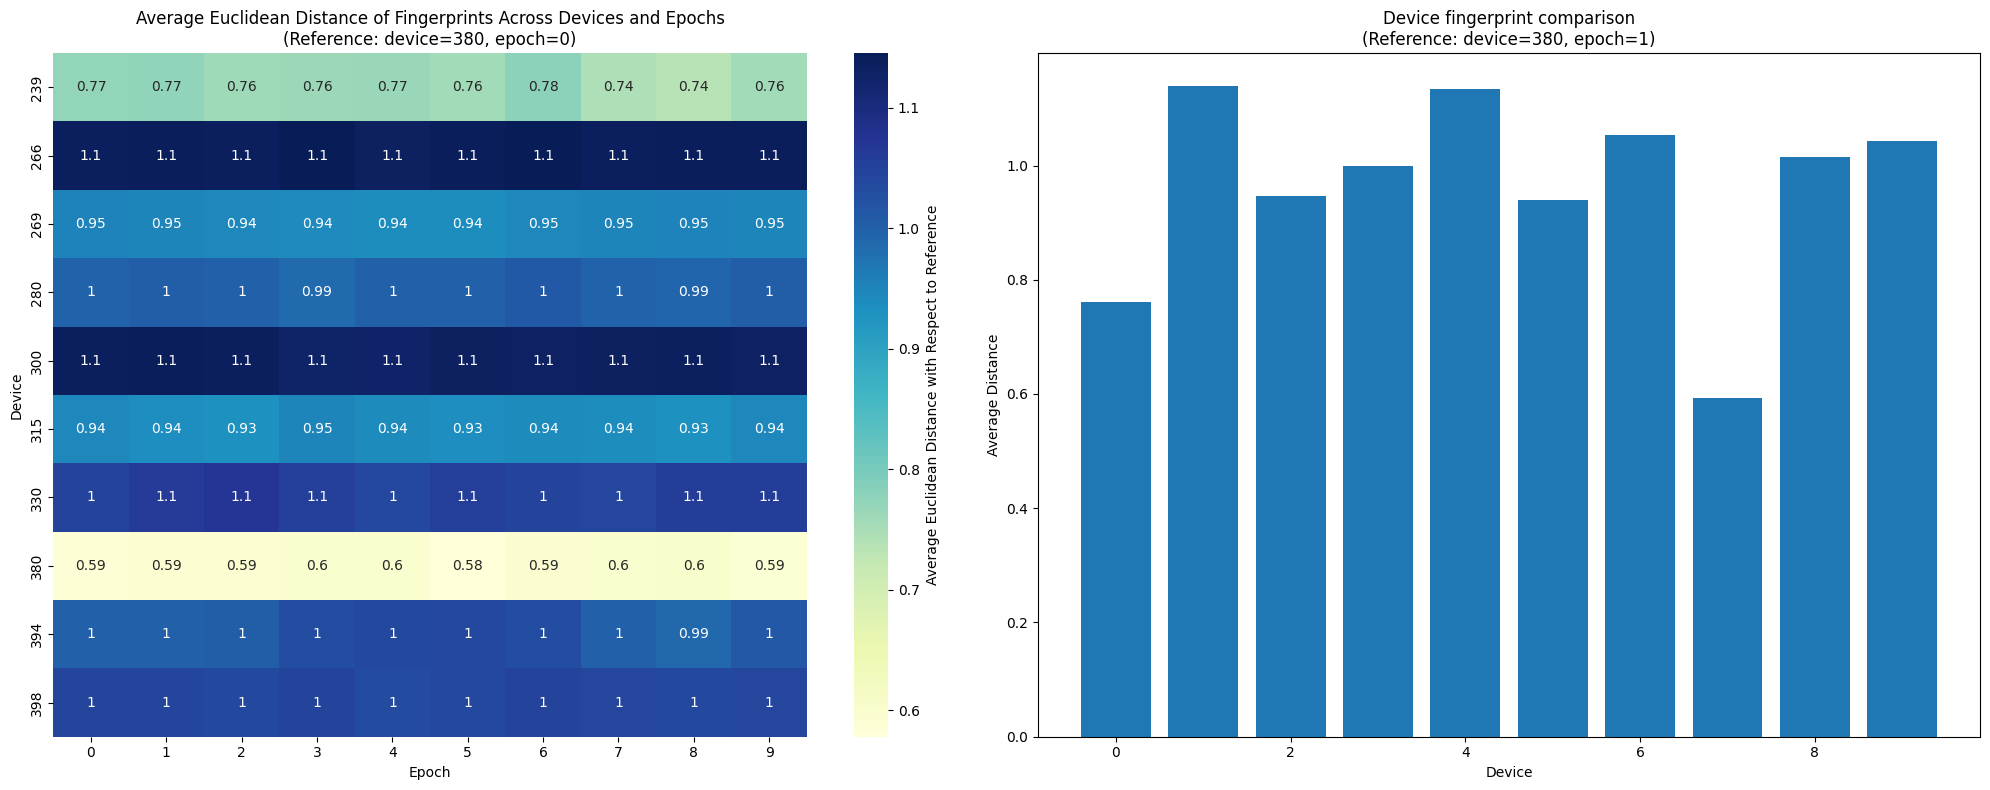

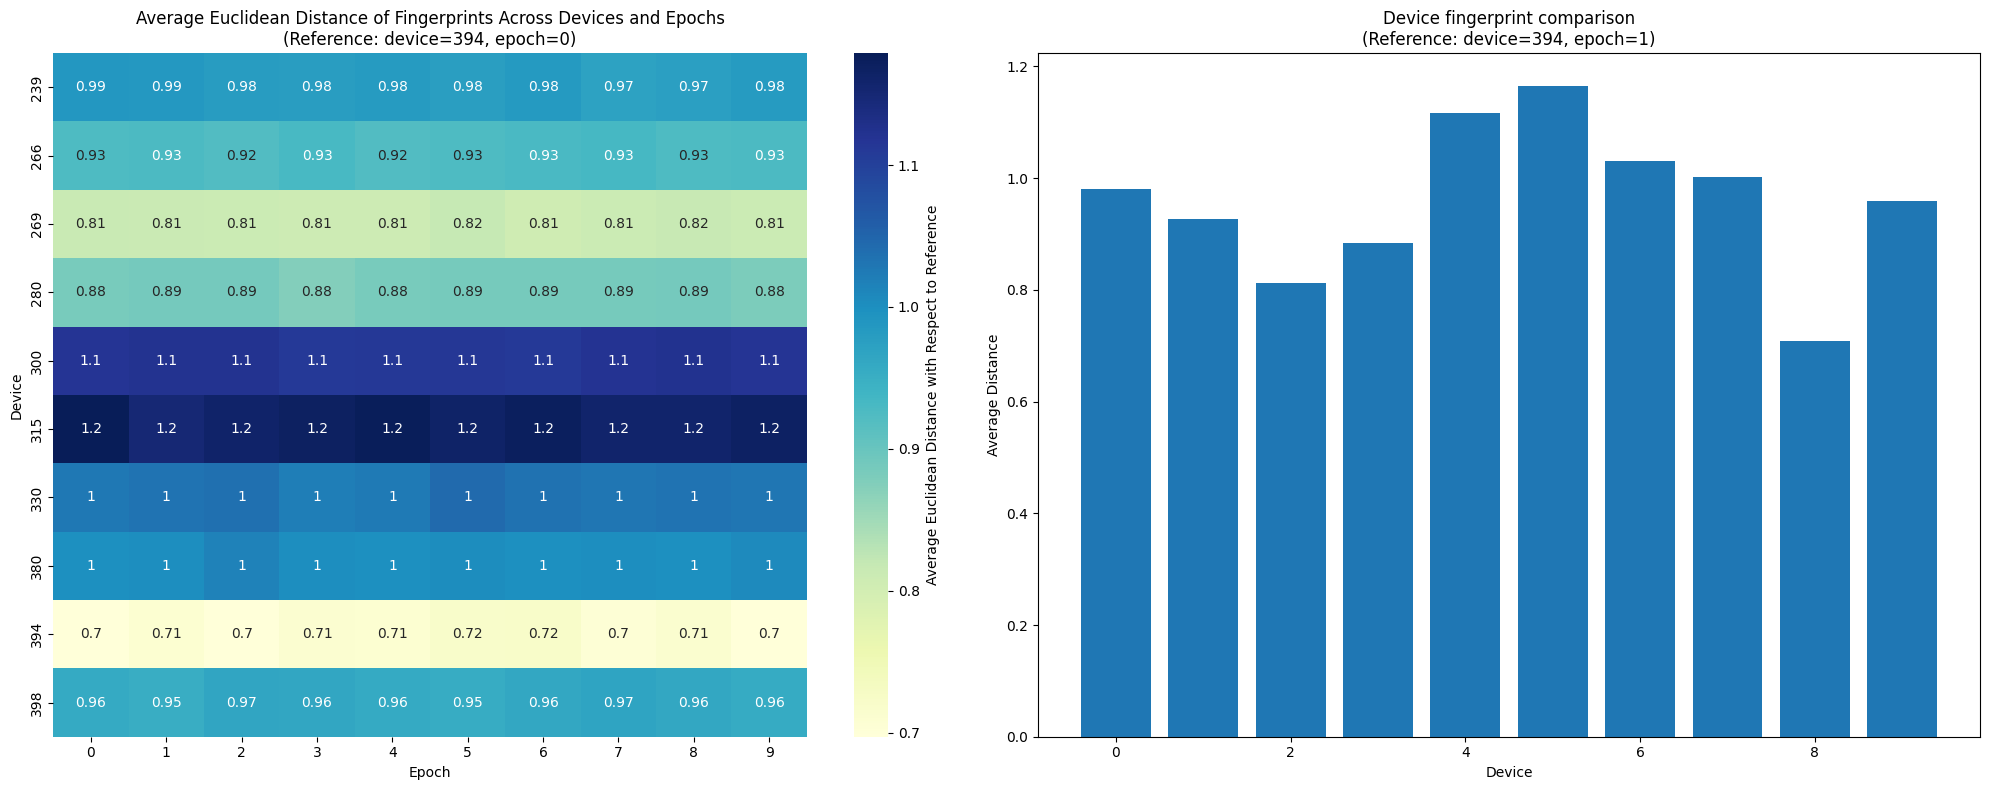

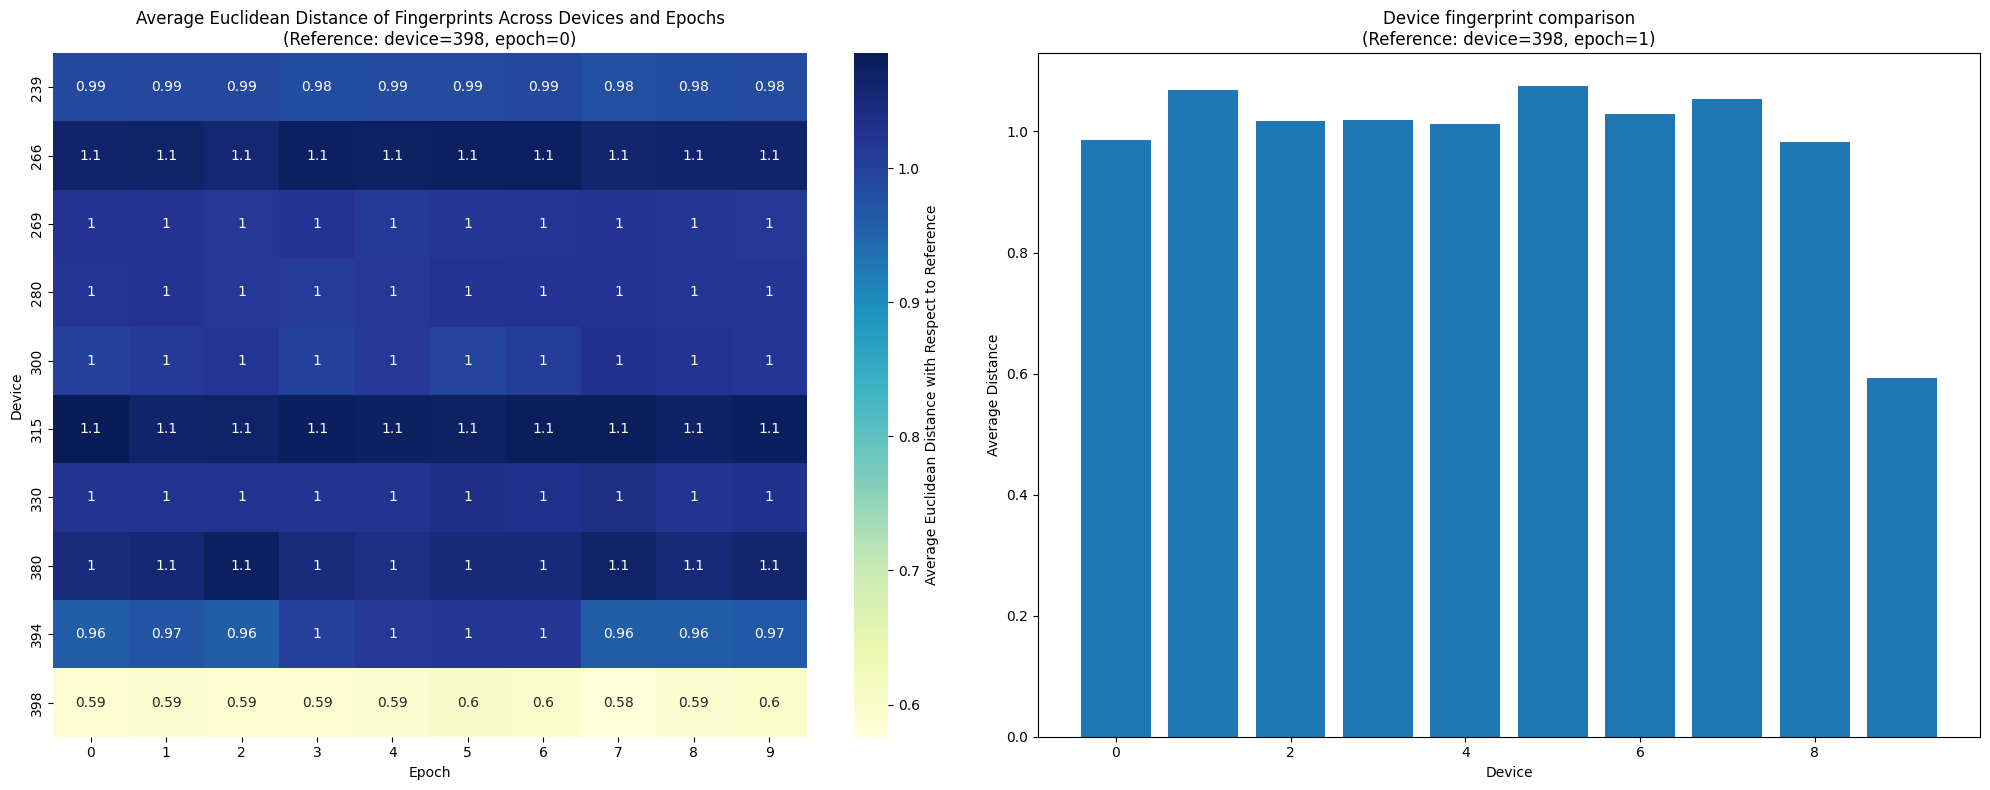

In [18]:
def evaluate_fingerprint_similarity(dev_range, fingerprints, device_idx, epoch_idx):
    N, M, K, D = fingerprints.shape

    # Extract reference fingerprints at device_idx and epoch_idx
    reference_fingerprints = fingerprints[device_idx, epoch_idx, :, :]

    # Initialize a matrix to store average distances with respect to reference fingerprints
    avg_distances = np.zeros((N, M))

    # Compute average Euclidean distance with respect to reference fingerprints for each device and epoch
    for i in range(N):
        for j in range(M):
            # Extract the K fingerprints for device i at epoch j
            data = fingerprints[i, j, :, :]
            # Compute the Euclidean distances between reference fingerprints and current fingerprints
            distances = cdist(reference_fingerprints, data, 'euclidean')
            # Average the distances
            avg_distance = np.mean(distances)
            avg_distances[i, j] = avg_distance

    # Plot the heatmaps side by side
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))

    # Plot the heatmap
    sns.heatmap(avg_distances, annot=True, cmap="YlGnBu", cbar_kws={'label': 'Average Euclidean Distance with Respect to Reference'}, yticklabels=dev_range, ax=axes[0])
    axes[0].set_title(f'Average Euclidean Distance of Fingerprints Across Devices and Epochs\n(Reference: device={dev_range[device_idx]}, epoch={epoch_idx})')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Device')

    # Plot the bar chart
    axes[1].bar(np.arange(avg_distances.shape[0]), np.mean(avg_distances, axis=1))
    axes[1].set_title(f"Device fingerprint comparison\n(Reference: device={dev_range[device_idx]}, epoch={epoch_idx+1})")
    axes[1].set_xlabel('Device')
    axes[1].set_ylabel('Average Distance')

    # Show the plots
    plt.tight_layout()
    plt.show()

# Example usage
for device_idx in np.arange(len(dev_range)):
    evaluate_fingerprint_similarity(dev_range, fingerprints, device_idx, 0)

In [211]:
# Devices from Orbit v2 dataset
# dev_range_enrol = np.array([1, 10, 20, 39, 239, 269, 280, 300, 315, 394, 398])
dev_range_enrol = np.array([1, 10])
dev_range_identify = np.array([1, 10, 20, 39, 239, 269, 280, 300, 315, 394, 398])
pkt_range_enrol = np.arange(0, 100)
pkt_range_identify = np.arange(0, 100)    

LoadDatasetObj = LoadDataset()
data_enrol, label_enrol = LoadDatasetObj.load_iq_samples(dataset_enrol, dev_range_enrol, pkt_range_enrol)
data_identify, true_label = LoadDatasetObj.load_iq_samples(dataset_identify, dev_range_identify, pkt_range_identify)
print(f"Data enrol shape: {data_enrol.shape}")
print(f"Data identify shape: {data_identify.shape}")

ChannelIndSpectrogramObj = ChannelIndSpectrogram()
data_enrol = ChannelIndSpectrogramObj.channel_ind_spectrogram(data_enrol)
data_identify = ChannelIndSpectrogramObj.channel_ind_spectrogram(data_identify)

print("Generating enrollment fingerprints...")
feature_enrol = feature_extractor.predict(data_enrol)
feature_identify = feature_extractor.predict(data_identify)

print(f"Enrolled fingerprints: {int(feature_enrol.shape[0] / pkt_range_enrol.shape[0])}")
print(f"Identification fingerprints: {int(feature_identify.shape[0] / pkt_range_identify.shape[0])}")

knnclf=KNeighborsClassifier(n_neighbors=15,metric='euclidean')
knnclf.fit(feature_enrol, np.ravel(label_enrol))
# pred_label = knnclf.predict(feature_identify)

# print('Overall accuracy = %.4f' % accuracy_score(true_label, pred_label))
# evaluate(true_label, pred_label, dev_range_identify)

Data enrol shape: (200, 400)
Data identify shape: (1100, 400)
Generating enrollment fingerprints...
35/35 [==============================] - 0s 2ms/step
Enrolled fingerprints: 2
Identification fingerprints: 11


KNeighborsClassifier(metric='euclidean', n_neighbors=15)

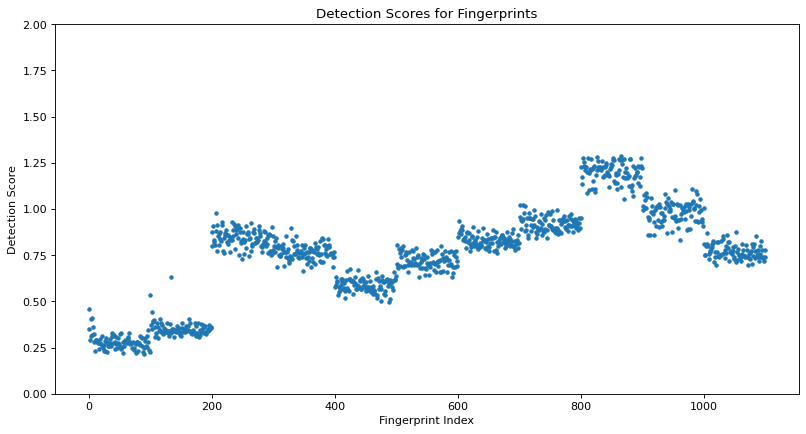

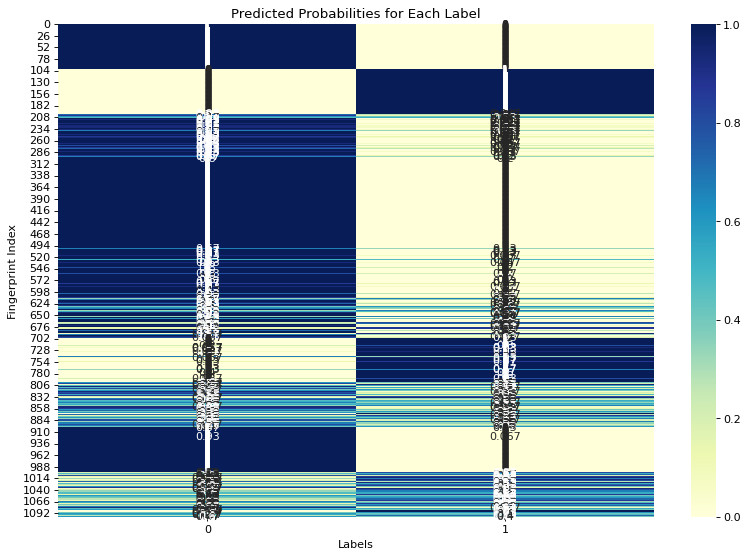

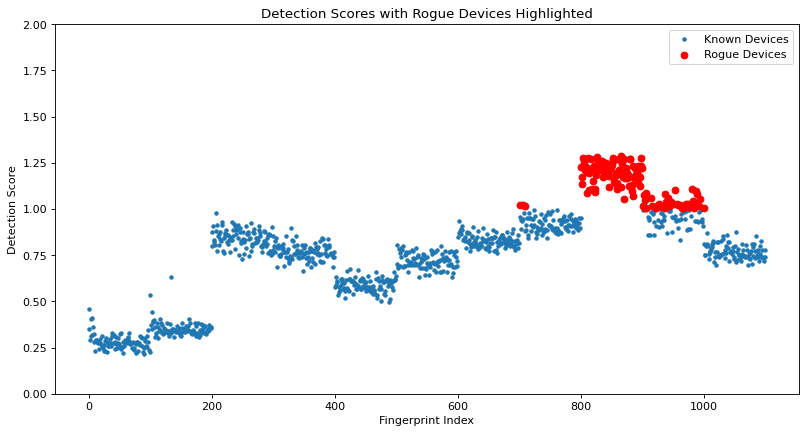

In [213]:
# Evaluating distances to unseen fingerprints
distances, indexes = knnclf.kneighbors(feature_identify)
detection_score = distances.mean(axis=1)

# Get the predicted probabilities for each class
predicted_probs = knnclf.predict_proba(feature_identify)

# Plotting the detection scores
plt.figure(figsize=(12, 6), dpi=80)
plt.scatter(np.arange(len(detection_score)), detection_score, marker=".")
plt.ylim(0, 2)
plt.xlabel('Fingerprint Index')
plt.ylabel('Detection Score')
plt.title('Detection Scores for Fingerprints')
plt.show()

# Plotting a heatmap of the predicted probabilities
plt.figure(figsize=(12, 8), dpi=80)
sns.heatmap(predicted_probs, cmap="YlGnBu", annot=True)
plt.xlabel('Labels')
plt.ylabel('Fingerprint Index')
plt.title('Predicted Probabilities for Each Label')
plt.show()

# Identify rogue devices using a heuristic threshold (e.g., mean detection score threshold)
threshold = 1.0  # Adjust this value based on your specific use case
rogue_indices = np.where(detection_score > threshold)[0]

# Plotting the detection scores with rogue devices highlighted
plt.figure(figsize=(12, 6), dpi=80)
plt.scatter(np.arange(len(detection_score)), detection_score, marker=".", label='Known Devices')
plt.scatter(rogue_indices, detection_score[rogue_indices], color='red', label='Rogue Devices')
plt.ylim(0, 2)
plt.xlabel('Fingerprint Index')
plt.ylabel('Detection Score')
plt.title('Detection Scores with Rogue Devices Highlighted')
plt.legend()
plt.show()

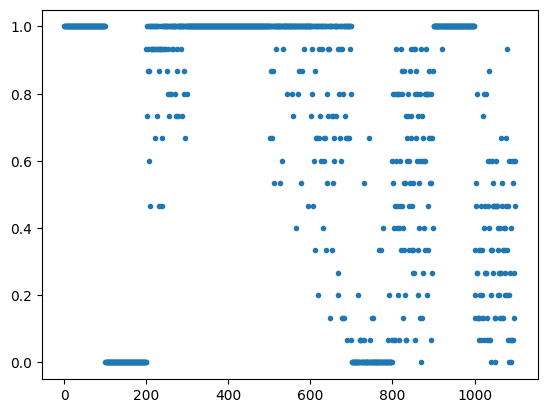

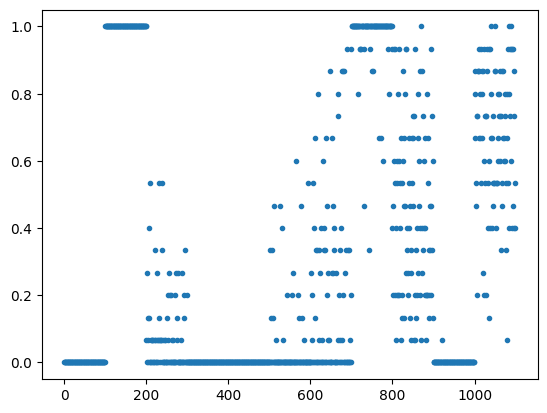

In [220]:
plt.scatter(np.arange(predicted_probs.shape[0]), predicted_probs[:, 0], marker='.')
plt.show()
plt.scatter(np.arange(predicted_probs.shape[0]), predicted_probs[:, 1], marker='.')
plt.show()

In [204]:
distances, indexes = knnclf.kneighbors(feature_identify)
detection_score = distances.mean(axis =1)

In [205]:
distances.shape

(1100, 1)

(0.0, 2.0)

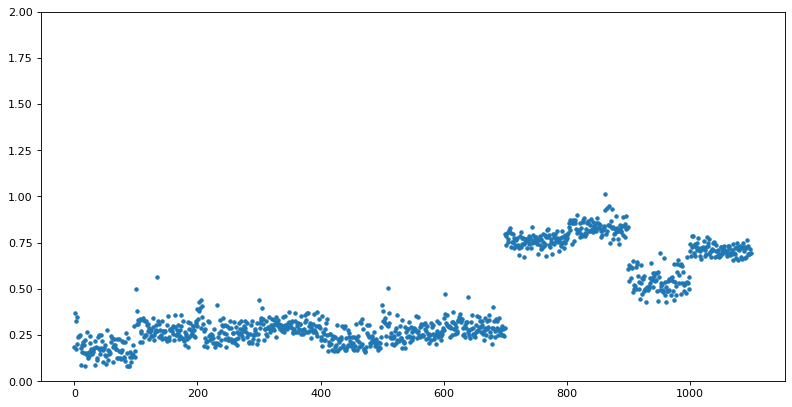

In [206]:
plt.figure(figsize=(12, 6), dpi=80)
plt.scatter(np.arange(len(detection_score)), detection_score, marker=".")
plt.ylim(0, 2)